# Run code block below to initilization

In [3]:
#@markdown ###Download a demo dataset

import requests
import zipfile
import io

# Define the Zenodo link
zenodo_link = "https://zenodo.org/records/11123445/files/data.zip?download=1"

# Download the file
response = requests.get(zenodo_link)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Specify the destination folder for extraction
destination_folder = '/content'


# Extract the contents of the zip file to the destination folder
zip_file.extractall(destination_folder)

# Close the zip file
zip_file.close()

!rm -rf data/__MACOSX/
!rm -rf __MACOSX/

In [6]:
%%capture
#@markdown ### initilization
import torch
print(torch.__version__)

!pip install csbdeep
import cv2
import numpy as np
import matplotlib.pyplot as plt
def showimg(src_img,ref_img,matched_img):
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(src_img, cmap='gray')
    plt.title('Source Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(ref_img, cmap='gray')
    plt.title('Reference Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(matched_img, cmap='gray')
    plt.title('Matched Image')
    plt.axis('off')

    plt.show()

def match_histograms(src_img, ref_img):

    src_hist, src_bins = np.histogram(src_img.flatten(), 256, [0,256])
    ref_hist, ref_bins = np.histogram(ref_img.flatten(), 256, [0,256])

    src_cdf = src_hist.cumsum() / src_hist.sum()
    ref_cdf = ref_hist.cumsum() / ref_hist.sum()

    cdf_mapping = np.zeros(256, dtype=np.uint8)
    j = 0
    for i in range(256):
        while ref_cdf[j] < src_cdf[i] and j < 255:
            j += 1
        cdf_mapping[i] = j

    src_img_matched = cdf_mapping[src_img.flatten()]
    src_img_matched = src_img_matched.reshape(src_img.shape).astype(np.uint8)

    return src_img_matched

def ezmatch(src_img, ref_img):
    avesrc = np.mean(src_img)
    averef = np.mean(ref_img)

    factor = averef/avesrc
    if True: #factor > 1.1 or factor < 0.9:
        src_img = factor*np.array(src_img)
        return src_img.astype(np.uint8)
    else:
        return src_img

import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageOps
from torchvision import transforms
import cv2
from skimage.feature import local_binary_pattern
from sklearn.model_selection import KFold
import json

# clahe = False #@param{type:"boolean"}
# edgeCanny = False #@param{type:"boolean"}
# lbp = False #@param{type:"boolean"}

class BasicDataset(Dataset):
    def __init__(self, images_dir, masks_dir,
                 augmentation=False, mirror=True, rotate=True,
                 clahe = clahe,
                 edgeCanny = edgeCanny,
                 lbp = lbp,
                 houghTransform = True,
                 surf = True):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.augmentation = augmentation
        self.clahe = clahe
        self.edgeCanny = edgeCanny
        self.lbp = lbp
        self.houghTransform = houghTransform
        self.surf = surf

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.7, 1.3), saturation=(0.8, 1.2)),
        ])
        # self.transtensor = transforms.ToTensor()

        self.images = [file for file in os.listdir(images_dir) if file.endswith('.png')]
        self.masks = [file for file in os.listdir(masks_dir) if file.endswith('.png')]
        # print(f'images: {len(self.images)}, masks: {len(self.masks)}')

        if self.augmentation:
            self.apply_augmentation(mirror, rotate)

    def apply_augmentation(self, mirror, rotate):
        for img_name in self.images:
            img_path = os.path.join(self.images_dir, img_name)
            image = Image.open(img_path).convert("L")

            if mirror:
                mirrored_image = ImageOps.mirror(image)
                mirrored_image.save(os.path.join(self.images_dir, f'mirror_{img_name}'))

            if rotate:
                rotated_image = image.rotate(180)
                rotated_image.save(os.path.join(self.images_dir, f'rotate_{img_name}'))

        for mask_name in self.masks:
            mask_path = os.path.join(self.masks_dir, mask_name)
            mask = Image.open(mask_path).convert("L")

            if mirror:
                mirrored_mask = ImageOps.mirror(mask)
                mirrored_mask.save(os.path.join(self.masks_dir, f'mirror_{mask_name}'))

            if rotate:
                rotated_mask = mask.rotate(180)
                rotated_mask.save(os.path.join(self.masks_dir, f'rotate_{mask_name}'))

        # Update the lists of images and masks after augmentation
        self.images = [file for file in os.listdir(self.images_dir) if file.endswith('.png')]
        self.masks = [file for file in os.listdir(self.masks_dir) if file.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        image_np = np.array(image)
        image_transform = self.transform(image_np)
        channels = [image_transform]
        channels[0] = channels[0].squeeze(0).numpy()

        if self.clahe:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image_clahe = clahe.apply(image_np)
            channels.append(image_clahe)

        if self.edgeCanny:
            edges = cv2.Canny(image_np, 100, 200)
            channels.append(edges)

        if self.lbp:
            lbp_image = local_binary_pattern(image_np, P=8, R=1, method="uniform")
            lbp_image_normalized = cv2.normalize(lbp_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            channels.append(lbp_image_normalized)

        # Stack all the channels together
        # print(len(channels))
        if len(channels) > 1:
            # print(channels[0].shape, channels[1].shape, channels[2].shape, channels[3].shape)
            image_combined = np.stack(channels, axis=-1)
        else:
            image_combined = channels[0]

        image_combined = torch.from_numpy(image_combined).float()
        # print(image_combined.size())
        if len(image_combined.size())==3:
            image_combined = image_combined.permute(2, 0, 1)
        else:
            image_combined = image_combined.unsqueeze(0)
        mask = torch.from_numpy(np.array(mask))

        return image_combined, mask


# Select and train one unet below

In [13]:
#@markdown ###small original unet
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np
import cv2

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_classes, bilinear=False, learn = 0.005, n_channels = 4):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
        # self.device = 'cpu'
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        ''' larger 1024 model
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes) '''

        ''' smaller 512 model
        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512 )
        self.up1 = Up(512, 256 )
        self.up2 = Up(256, 128 )
        self.up3 = Up(128, 64)
        self.up4 = Up(64, 32)
        self.outc = OutConv(32, n_classes)#'''

        #''' smaller 256 model
        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)

        self.up1 = Up(64, 32 )
        self.up2 = Up(32, 16 )

        self.outc = OutConv(16, n_classes)#'''

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)

        self.history = {"train_loss": [], "val_loss": []}

    def forward(self, x):
        input = x
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x = self.up1(x3, x2)
        x = self.up2(x2, x1)

        logits = self.outc(x)
        return logits

    def ce_loss(self, pred_mask, target_mask, weighted=False):
        target_mask = target_mask.squeeze(1).type(torch.long)
        if weighted:
            weight = torch.ones(pred_mask.shape[1], device=self.device)
            weight[0] = 10
            weight[1] = 10
            weight[2] = 10
            loss = F.cross_entropy(pred_mask, target_mask, weight=weight)
        else:
            loss = F.cross_entropy(pred_mask, target_mask)
        return loss

    def focal_loss(self, inputs, targets, alpha=0.25, gamma=2.0, epsilon=1e-9):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)  # [batch_size, 1, height, width] to [batch_size, height, width]
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        inputs = inputs.clamp(min=epsilon, max=1.0 - epsilon)
        pt = torch.where(torch.eq(targets, 1), inputs, 1 - inputs)
        loss = -alpha * (1 - pt) ** gamma * torch.log(pt)

        return loss.mean()

    def dice_loss(self, inputs, targets, smooth=1e-6):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = 2.0 * (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (intersection + smooth) / (union + smooth)

        return (1 - dice_score).mean()

    def combined_loss(self, inputs, targets, alpha=0.5, beta=0.5, gamma=2.0, smooth=1e-6):
        loss_focal = self.focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
        loss_dice = self.dice_loss(inputs, targets, smooth=smooth)
        return beta * loss_focal + (1 - beta) * loss_dice


    def train_step(self, inputs, target_mask, lossfunc):
        inputs, target_mask = inputs.to(self.device), target_mask.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_mask = self(inputs)
        mask_loss = lossfunc(pred_mask, target_mask)

        mask_loss.backward()
        self.optimizer.step()
        return mask_loss.item()

    def validate(self, val_loader, lossfunc):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask in val_loader:
                target_mask = target_mask.long()
                inputs, target_mask = inputs.to(device), target_mask.to(device)
                pred_mask = self(inputs)
                mask_loss = lossfunc(pred_mask, target_mask)
                total_loss += mask_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, epochs, batch_size, val_loader= None, loss='dice_loss', best_loss = 10):
        alloss = {'dice_loss': self.dice_loss, 'focal_loss': self.focal_loss,
                  'combined_loss': self.combined_loss, 'ce_loss': self.ce_loss}
        lossfunc = alloss[loss]

        for epoch in range(epochs):
            start_time = time.time()

            # n_val = int(len(full_dataset) * val_percent)
            # n_train = len(full_dataset) - n_val
            # train_subset, val_subset = torch.utils.data.random_split(full_dataset, [n_train, n_val])

            # train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            # val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

            total_train_loss = 0
            for inputs, target_mask in train_loader:
                target_mask = target_mask.long()
                mask_loss = self.train_step(inputs, target_mask, lossfunc)
                total_train_loss += mask_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader, lossfunc)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 0
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('best_unet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def predict(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            preds = self(x)
            preds = preds.argmax(dim=1)  #  (batch_size, height, width)

            preds = preds.float() / (self.n_classes - 1) * 255
            preds = preds.to(torch.uint8)

            return preds

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = UNet(n_channels = n_channels, n_classes = n_classes)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


In [ ]:
#@markdown ###original unet
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np
import cv2
class inConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_classes, bilinear=False, learn = 0.005, n_channels = 4):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
        # self.device = 'cpu'
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        ''' larger 1024 model
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes) '''

        #''' smaller 512 model
        self.inc = inConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512 )
        self.up1 = Up(512, 256 )
        self.up2 = Up(256, 128 )
        self.up3 = Up(128, 64)
        self.up4 = Up(64, 32)
        self.outc = OutConv(32, n_classes)#'''

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)

        self.history = {"train_loss": [], "val_loss": []}

    def forward(self, x):
        input = x
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def ce_loss(self, pred_mask, target_mask, weighted=False):
        target_mask = target_mask.squeeze(1).type(torch.long)
        if weighted:
            weight = torch.ones(pred_mask.shape[1], device=self.device)
            weight[0] = 10
            weight[1] = 10
            weight[2] = 10
            loss = F.cross_entropy(pred_mask, target_mask, weight=weight)
        else:
            loss = F.cross_entropy(pred_mask, target_mask)
        return loss

    def focal_loss(self, inputs, targets, alpha=0.25, gamma=2.0, epsilon=1e-9):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)  # [batch_size, 1, height, width] to [batch_size, height, width]
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        inputs = inputs.clamp(min=epsilon, max=1.0 - epsilon)
        pt = torch.where(torch.eq(targets, 1), inputs, 1 - inputs)
        loss = -alpha * (1 - pt) ** gamma * torch.log(pt)

        return loss.mean()

    def dice_loss(self, inputs, targets, smooth=1e-6):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = 2.0 * (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (intersection + smooth) / (union + smooth)

        return (1 - dice_score).mean()

    def combined_loss(self, inputs, targets, alpha=0.5, beta=0.5, gamma=2.0, smooth=1e-6):
        loss_focal = self.focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
        loss_dice = self.dice_loss(inputs, targets, smooth=smooth)
        return beta * loss_focal + (1 - beta) * loss_dice


    def train_step(self, inputs, target_mask, lossfunc):
        inputs, target_mask = inputs.to(self.device), target_mask.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_mask = self(inputs)
        mask_loss = lossfunc(pred_mask, target_mask)

        mask_loss.backward()
        self.optimizer.step()
        return mask_loss.item()

    def validate(self, val_loader, lossfunc):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask in val_loader:
                target_mask = target_mask.long()
                inputs, target_mask = inputs.to(device), target_mask.to(device)
                pred_mask = self(inputs)
                mask_loss = lossfunc(pred_mask, target_mask)
                total_loss += mask_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, epochs, batch_size, val_loader= None, loss='dice_loss', best_loss = 10):
        alloss = {'dice_loss': self.dice_loss, 'focal_loss': self.focal_loss,
                  'combined_loss': self.combined_loss, 'ce_loss': self.ce_loss}
        lossfunc = alloss[loss]

        for epoch in range(epochs):
            start_time = time.time()

            # n_val = int(len(full_dataset) * val_percent)
            # n_train = len(full_dataset) - n_val
            # train_subset, val_subset = torch.utils.data.random_split(full_dataset, [n_train, n_val])

            # train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            # val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

            total_train_loss = 0
            for inputs, target_mask in train_loader:
                target_mask = target_mask.long()
                mask_loss = self.train_step(inputs, target_mask, lossfunc)
                total_train_loss += mask_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader, lossfunc)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 0
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('best_unet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def predict(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            preds = self(x)
            preds = preds.argmax(dim=1)  #  (batch_size, height, width)

            preds = preds.float() / (self.n_classes - 1) * 255
            preds = preds.to(torch.uint8)

            return preds

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = UNet(n_channels = n_channels, n_classes = n_classes)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


In [ ]:
#@markdown ### Res - attention -  unet

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np
import cv2
class inConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        #print("gate",g.size(),'x', x.size())
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        #print(g1.size(), x1.size())
        diffY = x.size()[2] -g1.size()[2]
        diffX = x.size()[3] - g1.size()[3]
        g1 = F.pad(g1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, res = True):
        super().__init__()
        self.res = res
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )
        self.res = ResidualBlock(out_channels, out_channels)

    def forward(self, x):
        out = self.maxpool_conv(x)
        if self.res:
            out = self.res(out)
        return out

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False,
                 res = True):
        super().__init__()
        self.res = res
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        self.resconv = ResidualBlock(out_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        out = self.conv(x)
        if self.res:
            out = self.resconv(out)
        return out

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, learn = 0.0025,
                 resconv = True):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = inConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        self.att1 = AttentionGate(512, 256, 256)
        self.att2 = AttentionGate(256, 128, 128)
        self.att3 = AttentionGate(128, 64, 64)
        self.att4 = AttentionGate(64, 32, 32)

        self.up1 = Up(512, 256, bilinear, res = resconv)
        self.up2 = Up(256, 128, bilinear, res = resconv)
        self.up3 = Up(128, 64, bilinear, res = resconv)
        self.up4 = Up(64, 32, bilinear)

        self.outc = OutConv(32, n_classes)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.8)

        self.history = {"train_loss": [], "val_loss": []}

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)


        x4 = self.att1(x5, x4)
        x = self.up1(x5, x4)

        x3 = self.att2(x, x3)
        x = self.up2(x, x3)

        x2 = self.att3(x, x2)
        x = self.up3(x, x2)

        x1 = self.att4(x, x1)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits

    def ce_loss(self, pred_mask, target_mask, weighted=False):
        target_mask = target_mask.squeeze(1).type(torch.long)
        if weighted:
            weight = torch.ones(pred_mask.shape[1], device=self.device)
            weight[0] = 10
            weight[1] = 10
            weight[2] = 10
            loss = F.cross_entropy(pred_mask, target_mask, weight=weight)
        else:
            loss = F.cross_entropy(pred_mask, target_mask)
        return loss

    def focal_loss(self, inputs, targets, alpha=0.25, gamma=2.0, epsilon=1e-9):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)  # [batch_size, 1, height, width] to [batch_size, height, width]
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        inputs = inputs.clamp(min=epsilon, max=1.0 - epsilon)
        pt = torch.where(torch.eq(targets, 1), inputs, 1 - inputs)
        loss = -alpha * (1 - pt) ** gamma * torch.log(pt)

        return loss.mean()

    def dice_loss(self, inputs, targets, smooth=1e-6):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()
        intersection = 2.0 * (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (intersection + smooth) / (union + smooth)

        return (1 - dice_score).mean()

    def combined_loss(self, inputs, targets, alpha=0.5, beta=0.5, gamma=2.0, smooth=1e-6):
        loss_focal = self.focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
        loss_dice = self.dice_loss(inputs, targets, smooth=smooth)
        return beta * loss_focal + (1 - beta) * loss_dice


    def train_step(self, inputs, target_mask, lossfunc):
        inputs, target_mask = inputs.to(self.device), target_mask.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_mask = self(inputs)
        mask_loss = lossfunc(pred_mask, target_mask)

        mask_loss.backward()
        self.optimizer.step()
        return mask_loss.item()

    def validate(self, val_loader, lossfunc):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask in val_loader:
                target_mask = target_mask.long()
                inputs, target_mask = inputs.to(device), target_mask.to(device)
                pred_mask = self(inputs)
                mask_loss = lossfunc(pred_mask, target_mask)
                total_loss += mask_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, epochs, batch_size, val_loader= None, loss='dice_loss', best_loss = 10):
        alloss = {'dice_loss': self.dice_loss, 'focal_loss': self.focal_loss,
                  'combined_loss': self.combined_loss, 'ce_loss': self.ce_loss}
        lossfunc = alloss[loss]

        for epoch in range(epochs):
            start_time = time.time()

            # n_val = int(len(full_dataset) * val_percent)
            # n_train = len(full_dataset) - n_val
            # train_subset, val_subset = torch.utils.data.random_split(full_dataset, [n_train, n_val])

            # train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            # val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

            total_train_loss = 0
            for inputs, target_mask in train_loader:
                target_mask = target_mask.long()
                mask_loss = self.train_step(inputs, target_mask, lossfunc)
                total_train_loss += mask_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader, lossfunc)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 0
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('best_unet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def predict(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            preds = self(x)
            preds = preds.argmax(dim=1)  #  (batch_size, height, width)

            preds = preds.float() / (self.n_classes - 1) * 255
            preds = preds.to(torch.uint8)

            return preds

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = UNet(n_channels, n_classes, bilinear)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


In [ ]:
#@markdown ### Res -  unet

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np
import cv2

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        #print("gate",g.size(),'x', x.size())
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        #print(g1.size(), x1.size())
        diffY = x.size()[2] -g1.size()[2]
        diffX = x.size()[3] - g1.size()[3]
        g1 = F.pad(g1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class inConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, res = True):
        super().__init__()
        self.res = res
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )
        self.res = ResidualBlock(out_channels, out_channels)

    def forward(self, x):
        out = self.maxpool_conv(x)
        if self.res:
            out = self.res(out)
        return out

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False,
                 res = True):
        super().__init__()
        self.res = res
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        self.resconv = ResidualBlock(out_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        out = self.conv(x)
        if self.res:
            out = self.resconv(out)
        return out

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, learn = 0.0025,
                 resconv = True):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = inConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        self.att1 = AttentionGate(512, 256, 256)
        self.att2 = AttentionGate(256, 128, 128)
        self.att3 = AttentionGate(128, 64, 64)
        self.att4 = AttentionGate(64, 32, 32)

        self.up1 = Up(512, 256, bilinear, res = resconv)
        self.up2 = Up(256, 128, bilinear, res = resconv)
        self.up3 = Up(128, 64, bilinear, res = resconv)
        self.up4 = Up(64, 32, bilinear)

        self.outc = OutConv(32, n_classes)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.8)

        self.history = {"train_loss": [], "val_loss": []}

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)


        #x4 = self.att1(x5, x4)
        x = self.up1(x5, x4)

        #x3 = self.att2(x, x3)
        x = self.up2(x, x3)

        #x2 = self.att3(x, x2)
        x = self.up3(x, x2)

        #x1 = self.att4(x, x1)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits

    def ce_loss(self, pred_mask, target_mask, weighted=False):
        target_mask = target_mask.squeeze(1).type(torch.long)
        if weighted:
            weight = torch.ones(pred_mask.shape[1], device=self.device)
            weight[0] = 10
            weight[1] = 10
            weight[2] = 10
            loss = F.cross_entropy(pred_mask, target_mask, weight=weight)
        else:
            loss = F.cross_entropy(pred_mask, target_mask)
        return loss

    def focal_loss(self, inputs, targets, alpha=0.25, gamma=2.0, epsilon=1e-9):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)  # [batch_size, 1, height, width] to [batch_size, height, width]
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        inputs = inputs.clamp(min=epsilon, max=1.0 - epsilon)
        pt = torch.where(torch.eq(targets, 1), inputs, 1 - inputs)
        loss = -alpha * (1 - pt) ** gamma * torch.log(pt)

        return loss.mean()

    def dice_loss(self, inputs, targets, smooth=1e-6):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()
        intersection = 2.0 * (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (intersection + smooth) / (union + smooth)

        return (1 - dice_score).mean()

    def combined_loss(self, inputs, targets, alpha=0.5, beta=0.5, gamma=2.0, smooth=1e-6):
        loss_focal = self.focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
        loss_dice = self.dice_loss(inputs, targets, smooth=smooth)
        return beta * loss_focal + (1 - beta) * loss_dice


    def train_step(self, inputs, target_mask, lossfunc):
        inputs, target_mask = inputs.to(self.device), target_mask.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_mask = self(inputs)
        mask_loss = lossfunc(pred_mask, target_mask)

        mask_loss.backward()
        self.optimizer.step()
        return mask_loss.item()

    def validate(self, val_loader, lossfunc):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask in val_loader:
                target_mask = target_mask.long()
                inputs, target_mask = inputs.to(device), target_mask.to(device)
                pred_mask = self(inputs)
                mask_loss = lossfunc(pred_mask, target_mask)
                total_loss += mask_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, epochs, batch_size, val_loader= None, loss='dice_loss', best_loss = 10):
        alloss = {'dice_loss': self.dice_loss, 'focal_loss': self.focal_loss,
                  'combined_loss': self.combined_loss, 'ce_loss': self.ce_loss}
        lossfunc = alloss[loss]

        for epoch in range(epochs):
            start_time = time.time()

            # n_val = int(len(full_dataset) * val_percent)
            # n_train = len(full_dataset) - n_val
            # train_subset, val_subset = torch.utils.data.random_split(full_dataset, [n_train, n_val])

            # train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            # val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

            total_train_loss = 0
            for inputs, target_mask in train_loader:
                target_mask = target_mask.long()
                mask_loss = self.train_step(inputs, target_mask, lossfunc)
                total_train_loss += mask_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader, lossfunc)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 0
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('best_unet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def predict(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            preds = self(x)
            preds = preds.argmax(dim=1)  #  (batch_size, height, width)

            preds = preds.float() / (self.n_classes - 1) * 255
            preds = preds.to(torch.uint8)

            return preds

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = UNet(n_channels, n_classes, bilinear)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


In [ ]:
#@markdown ### att -  unet

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np
import cv2

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        #print("gate",g.size(),'x', x.size())
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        #print(g1.size(), x1.size())
        diffY = x.size()[2] -g1.size()[2]
        diffX = x.size()[3] - g1.size()[3]
        g1 = F.pad(g1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, res = False):
        super().__init__()
        self.res = res
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )
        self.resfunc = ResidualBlock(out_channels, out_channels)

    def forward(self, x):
        out = self.maxpool_conv(x)
        return out

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False,
                 res = False):
        super().__init__()
        self.res = res
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        self.resconv = ResidualBlock(out_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        out = self.conv(x)
        return out
class inConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, learn = 0.0025,
                 resconv = True):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = inConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        self.att1 = AttentionGate(512, 256, 256)
        self.att2 = AttentionGate(256, 128, 128)
        self.att3 = AttentionGate(128, 64, 64)
        self.att4 = AttentionGate(64, 32, 32)

        self.up1 = Up(512, 256, bilinear, res = resconv)
        self.up2 = Up(256, 128, bilinear, res = resconv)
        self.up3 = Up(128, 64, bilinear, res = resconv)
        self.up4 = Up(64, 32, bilinear)

        self.outc = OutConv(32, n_classes)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.8)

        self.history = {"train_loss": [], "val_loss": []}

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)


        x4 = self.att1(x5, x4)
        x = self.up1(x5, x4)

        x3 = self.att2(x, x3)
        x = self.up2(x, x3)

        x2 = self.att3(x, x2)
        x = self.up3(x, x2)

        x1 = self.att4(x, x1)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits

    def ce_loss(self, pred_mask, target_mask, weighted=False):
        target_mask = target_mask.squeeze(1).type(torch.long)
        if weighted:
            weight = torch.ones(pred_mask.shape[1], device=self.device)
            weight[0] = 10
            weight[1] = 10
            weight[2] = 10
            loss = F.cross_entropy(pred_mask, target_mask, weight=weight)
        else:
            loss = F.cross_entropy(pred_mask, target_mask)
        return loss

    def focal_loss(self, inputs, targets, alpha=0.25, gamma=2.0, epsilon=1e-9):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)  # [batch_size, 1, height, width] to [batch_size, height, width]
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        inputs = inputs.clamp(min=epsilon, max=1.0 - epsilon)
        pt = torch.where(torch.eq(targets, 1), inputs, 1 - inputs)
        loss = -alpha * (1 - pt) ** gamma * torch.log(pt)

        return loss.mean()

    def dice_loss(self, inputs, targets, smooth=1e-6):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()
        intersection = 2.0 * (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (intersection + smooth) / (union + smooth)

        return (1 - dice_score).mean()

    def combined_loss(self, inputs, targets, alpha=0.5, beta=0.5, gamma=2.0, smooth=1e-6):
        loss_focal = self.focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
        loss_dice = self.dice_loss(inputs, targets, smooth=smooth)
        return beta * loss_focal + (1 - beta) * loss_dice


    def train_step(self, inputs, target_mask, lossfunc):
        inputs, target_mask = inputs.to(self.device), target_mask.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_mask = self(inputs)
        mask_loss = lossfunc(pred_mask, target_mask)

        mask_loss.backward()
        self.optimizer.step()
        return mask_loss.item()

    def validate(self, val_loader, lossfunc):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask in val_loader:
                target_mask = target_mask.long()
                inputs, target_mask = inputs.to(device), target_mask.to(device)
                pred_mask = self(inputs)
                mask_loss = lossfunc(pred_mask, target_mask)
                total_loss += mask_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, epochs, batch_size, val_loader= None, loss='dice_loss', best_loss = 10):
        alloss = {'dice_loss': self.dice_loss, 'focal_loss': self.focal_loss,
                  'combined_loss': self.combined_loss, 'ce_loss': self.ce_loss}
        lossfunc = alloss[loss]

        for epoch in range(epochs):
            start_time = time.time()

            # n_val = int(len(full_dataset) * val_percent)
            # n_train = len(full_dataset) - n_val
            # train_subset, val_subset = torch.utils.data.random_split(full_dataset, [n_train, n_val])

            # train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            # val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

            total_train_loss = 0
            for inputs, target_mask in train_loader:
                target_mask = target_mask.long()
                mask_loss = self.train_step(inputs, target_mask, lossfunc)
                total_train_loss += mask_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader, lossfunc)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 0
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('best_unet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def predict(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            preds = self(x)
            preds = preds.argmax(dim=1)  #  (batch_size, height, width)

            preds = preds.float() / (self.n_classes - 1) * 255
            preds = preds.to(torch.uint8)

            return preds

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = UNet(n_channels, n_classes, bilinear)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


In [ ]:
#@markdown ###deeps unet
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np
import cv2

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

def match_size(source, target):
    # print(f'targer:{target.size()}, source: {source.size()}')
    return F.interpolate(source, size=target.shape[1:], mode='bilinear', align_corners=False)

class inConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=4, bilinear=False, learn = 0.005, n_channels = 1):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')

        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        ''' larger 1024 model
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes) '''

        #''' smaller 512 model
        self.inc = inConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512 )

        self.up1 = Up(512, 256 )
        self.up2 = Up(256, 128 )
        self.up3 = Up(128, 64)
        self.up4 = Up(64, 32)

        self.out1 = OutConv(256, n_classes)
        self.out2 = OutConv(128, n_classes)
        self.out3 = OutConv(64, n_classes)
        self.outc = OutConv(32, n_classes)#'''

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)

        self.history = {"train_loss": [], "val_loss": []}

    def forward(self, x):
        input = x
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        out1 = self.out1(x)
        x = self.up2(x, x3)
        out2 = self.out2(x)
        x = self.up3(x, x2)
        out3 = self.out3(x)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits, out1, out2, out3

    def ce_loss(self, pred_mask, target_mask, weighted=False):
        target_mask = target_mask.squeeze(1).type(torch.long)
        inputs = F.softmax(pred_mask, dim=1)
        if weighted:
            weight = torch.ones(pred_mask.shape[1], device=self.device)
            weight[0] = 10
            weight[1] = 10
            weight[2] = 10
            loss = F.cross_entropy(inputs, target_mask, weight=weight)
        else:
            loss = F.cross_entropy(inputs, target_mask)
        return loss

    def focal_loss(self, inputs, targets, alpha=0.25, gamma=2.0, epsilon=1e-9):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)  # [batch_size, 1, height, width] to [batch_size, height, width]
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        inputs = inputs.clamp(min=epsilon, max=1.0 - epsilon)
        pt = torch.where(torch.eq(targets, 1), inputs, 1 - inputs)
        loss = -alpha * (1 - pt) ** gamma * torch.log(pt)

        return loss.mean()

    def dice_loss(self, inputs, targets, smooth=1e-6):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = 2.0 * (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (intersection + smooth) / (union + smooth)

        return (1 - dice_score).mean()

    def combined_loss(self, inputs, targets, alpha=0.5, beta=0.5, gamma=2.0, smooth=1e-6):
        loss_focal = self.focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
        loss_dice = self.dice_loss(inputs, targets, smooth=smooth)
        return beta * loss_focal + (1 - beta) * loss_dice


    def train_step(self, inputs, target_mask, lossfunc):
        inputs, target_mask = inputs.to(self.device), target_mask.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_mask, out1, out2, out3 = self(inputs)
        mask_loss = lossfunc(pred_mask, target_mask)
        mask_loss1 = lossfunc(match_size(out1,target_mask), target_mask)
        mask_loss2 = lossfunc(match_size(out2,target_mask), target_mask)
        mask_loss3 = lossfunc(match_size(out3,target_mask), target_mask)
        all = mask_loss+mask_loss1+mask_loss2+mask_loss3

        all.backward()
        self.optimizer.step()
        # print(f'mask loss:{mask_loss}, loss1{mask_loss1}, loss2{mask_loss2}, loss3:{mask_loss3}')
        return mask_loss.item()

    def validate(self, val_loader, lossfunc):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask in val_loader:
                target_mask = target_mask.long()
                inputs, target_mask = inputs.to(device), target_mask.to(device)
                pred_mask, out1, out2, out3 = self(inputs)
                mask_loss = lossfunc(pred_mask, target_mask)

                total_loss += mask_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, epochs, batch_size, val_loader= None, loss='dice_loss', best_loss = 10):
        alloss = {'dice_loss': self.dice_loss, 'focal_loss': self.focal_loss,
                  'combined_loss': self.combined_loss, 'ce_loss': self.ce_loss}
        lossfunc = alloss[loss]

        for epoch in range(epochs):
            start_time = time.time()

            # n_val = int(len(full_dataset) * val_percent)
            # n_train = len(full_dataset) - n_val
            # train_subset, val_subset = torch.utils.data.random_split(full_dataset, [n_train, n_val])

            # train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            # val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

            total_train_loss = 0
            for inputs, target_mask in train_loader:
                target_mask = target_mask.long()
                mask_loss = self.train_step(inputs, target_mask, lossfunc)
                total_train_loss += mask_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader, lossfunc)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 0
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('best_unet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def predict(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            preds = self(x)
            preds = preds.argmax(dim=1)  #  (batch_size, height, width)

            preds = preds.float() / (self.n_classes - 1) * 255
            preds = preds.to(torch.uint8)

            return preds

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = UNet(n_channels = n_channels, n_classes = n_classes)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


In [ ]:
#@markdown ### Attention - deep - unet

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np
import cv2
def match_size(source, target):
    # print(f'targer:{target.size()}, source: {source.size()}')
    return F.interpolate(source, size=target.shape[1:], mode='bilinear', align_corners=False)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        #print("gate",g.size(),'x', x.size())
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        #print(g1.size(), x1.size())
        diffY = x.size()[2] -g1.size()[2]
        diffX = x.size()[3] - g1.size()[3]
        g1 = F.pad(g1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class inConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, res = False):
        super().__init__()
        self.res = res
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        out = self.maxpool_conv(x)

        return out

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False,
                 res = False):
        super().__init__()
        self.res = res
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        out = self.conv(x)

        return out

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, learn = 0.0025,
                 resconv = True):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = inConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        self.att1 = AttentionGate(512, 256, 256)
        self.att2 = AttentionGate(256, 128, 128)
        self.att3 = AttentionGate(128, 64, 64)
        self.att4 = AttentionGate(64, 32, 32)

        self.up1 = Up(512, 256, bilinear, res = resconv)
        self.up2 = Up(256, 128, bilinear, res = resconv)
        self.up3 = Up(128, 64, bilinear, res = resconv)
        self.up4 = Up(64, 32, bilinear)

        self.out1 = OutConv(256, n_classes)
        self.out2 = OutConv(128, n_classes)
        self.out3 = OutConv(64, n_classes)
        self.outc = OutConv(32, n_classes)

        # self.inc = inConv(n_channels, 64)
        # self.down1 = Down(64, 128)
        # self.down2 = Down(128, 256)
        # self.down3 = Down(256, 512)
        # self.down4 = Down(512, 1024)

        # self.att1 = AttentionGate(1024, 512, 512)
        # self.att2 = AttentionGate(512, 256, 256)
        # self.att3 = AttentionGate(256, 128, 128)
        # self.att4 = AttentionGate(128, 64, 64)

        # self.up1 = Up(1024, 512, bilinear, res = resconv)
        # self.up2 = Up(512, 256, bilinear, res = resconv)
        # self.up3 = Up(256, 128, bilinear, res = resconv)
        # self.up4 = Up(128, 64, bilinear)

        # self.out1 = OutConv(512, n_classes)
        # self.out2 = OutConv(256, n_classes)
        # self.out3 = OutConv(128, n_classes)
        # self.outc = OutConv(64, n_classes)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.8)

        self.history = {"train_loss": [], "val_loss": []}

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)


        x4 = self.att1(x5, x4)
        x = self.up1(x5, x4)
        out1 = self.out1(x)

        x3 = self.att2(x, x3)
        x = self.up2(x, x3)
        out2 = self.out2(x)

        x2 = self.att3(x, x2)
        x = self.up3(x, x2)
        out3 = self.out3(x)

        x1 = self.att4(x, x1)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits, out1, out2, out3

    def ce_loss(self, pred_mask, target_mask, weighted=False):
        target_mask = target_mask.squeeze(1).type(torch.long)
        if weighted:
            weight = torch.ones(pred_mask.shape[1], device=self.device)
            weight[0] = 10
            weight[1] = 10
            weight[2] = 10
            loss = F.cross_entropy(pred_mask, target_mask, weight=weight)
        else:
            loss = F.cross_entropy(pred_mask, target_mask)
        return loss

    def focal_loss(self, inputs, targets, alpha=0.25, gamma=2.0, epsilon=1e-9):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)  # [batch_size, 1, height, width] to [batch_size, height, width]
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        inputs = inputs.clamp(min=epsilon, max=1.0 - epsilon)
        pt = torch.where(torch.eq(targets, 1), inputs, 1 - inputs)
        loss = -alpha * (1 - pt) ** gamma * torch.log(pt)

        return loss.mean()

    def dice_loss(self,inputs, targets, class_weights=[0.5, 1, 1.5, 1], smooth=1e-6):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = 2.0 * (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (intersection + smooth) / (union + smooth)

        class_weights = torch.tensor(class_weights, device=inputs.device, dtype=inputs.dtype)
        dice_loss = (1 - dice_score) * class_weights

        return dice_loss.mean()

    def combined_loss(self, inputs, targets, alpha=0.5, beta=0.5, gamma=2.0, smooth=1e-6):
        loss_focal = self.focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
        loss_dice = self.dice_loss(inputs, targets, smooth=smooth)
        return beta * loss_focal + (1 - beta) * loss_dice


    def train_step(self, inputs, target_mask, lossfunc):
        inputs, target_mask = inputs.to(self.device), target_mask.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_mask, out1, out2, out3 = self(inputs)
        mask_loss = lossfunc(pred_mask, target_mask)
        mask_loss1 = lossfunc(match_size(out1,target_mask), target_mask)
        mask_loss2 = lossfunc(match_size(out2,target_mask), target_mask)
        mask_loss3 = lossfunc(match_size(out3,target_mask), target_mask)
        all = mask_loss+mask_loss1+mask_loss2+mask_loss3

        all.backward()
        self.optimizer.step()
        # print(f'mask loss:{mask_loss}, loss1{mask_loss1}, loss2{mask_loss2}, loss3:{mask_loss3}')
        return mask_loss.item()

        mask_loss.backward()
        self.optimizer.step()
        return mask_loss.item()

    def validate(self, val_loader, lossfunc):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask in val_loader:
                target_mask = target_mask.long()
                inputs, target_mask = inputs.to(device), target_mask.to(device)
                pred_mask, out1, out2, out3 = self(inputs)
                mask_loss = lossfunc(pred_mask, target_mask)
                total_loss += mask_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, epochs, batch_size, val_loader= None, loss='dice_loss', best_loss = 10):
        alloss = {'dice_loss': self.dice_loss, 'focal_loss': self.focal_loss,
                  'combined_loss': self.combined_loss, 'ce_loss': self.ce_loss}
        lossfunc = alloss[loss]

        for epoch in range(epochs):
            start_time = time.time()

            # n_val = int(len(full_dataset) * val_percent)
            # n_train = len(full_dataset) - n_val
            # train_subset, val_subset = torch.utils.data.random_split(full_dataset, [n_train, n_val])

            # train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            # val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

            total_train_loss = 0
            for inputs, target_mask in train_loader:
                target_mask = target_mask.long()
                mask_loss = self.train_step(inputs, target_mask, lossfunc)
                total_train_loss += mask_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader, lossfunc)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 0
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('/content/best_unet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def predict(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            preds = self(x)
            preds = preds.argmax(dim=1)  #  (batch_size, height, width)

            preds = preds.float() / (self.n_classes - 1) * 255
            preds = preds.to(torch.uint8)

            return preds

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = UNet(n_channels, n_classes, bilinear)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


In [ ]:
#@markdown ### Res - attention - deep - unet

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np
import cv2
def match_size(source, target):
    # print(f'targer:{target.size()}, source: {source.size()}')
    return F.interpolate(source, size=target.shape[1:], mode='bilinear', align_corners=False)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        #print("gate",g.size(),'x', x.size())
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        #print(g1.size(), x1.size())
        diffY = x.size()[2] -g1.size()[2]
        diffX = x.size()[3] - g1.size()[3]
        g1 = F.pad(g1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class inConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, res = True):
        super().__init__()
        self.res = res
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )
        self.res = ResidualBlock(out_channels, out_channels)

    def forward(self, x):
        out = self.maxpool_conv(x)
        if self.res:
            out = self.res(out)
        return out

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False,
                 res = False):
        super().__init__()
        self.res = res
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        self.resconv = ResidualBlock(out_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        out = self.conv(x)
        if self.res:
            out = self.resconv(out)
        return out

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, learn = 0.0025,
                 resconv = True):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = inConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        self.att1 = AttentionGate(512, 256, 256)
        self.att2 = AttentionGate(256, 128, 128)
        self.att3 = AttentionGate(128, 64, 64)
        self.att4 = AttentionGate(64, 32, 32)

        self.up1 = Up(512, 256, bilinear, res = resconv)
        self.up2 = Up(256, 128, bilinear, res = resconv)
        self.up3 = Up(128, 64, bilinear, res = resconv)
        self.up4 = Up(64, 32, bilinear)

        self.out1 = OutConv(256, n_classes)
        self.out2 = OutConv(128, n_classes)
        self.out3 = OutConv(64, n_classes)
        self.outc = OutConv(32, n_classes)

        # self.inc = inConv(n_channels, 64)
        # self.down1 = Down(64, 128)
        # self.down2 = Down(128, 256)
        # self.down3 = Down(256, 512)
        # self.down4 = Down(512, 1024)

        # self.att1 = AttentionGate(1024, 512, 512)
        # self.att2 = AttentionGate(512, 256, 256)
        # self.att3 = AttentionGate(256, 128, 128)
        # self.att4 = AttentionGate(128, 64, 64)

        # self.up1 = Up(1024, 512, bilinear, res = resconv)
        # self.up2 = Up(512, 256, bilinear, res = resconv)
        # self.up3 = Up(256, 128, bilinear, res = resconv)
        # self.up4 = Up(128, 64, bilinear)

        # self.out1 = OutConv(512, n_classes)
        # self.out2 = OutConv(256, n_classes)
        # self.out3 = OutConv(128, n_classes)
        # self.outc = OutConv(64, n_classes)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.8)

        self.history = {"train_loss": [], "val_loss": []}

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        coveg=x2
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        pooleg=x5

        x4 = self.att1(x5, x4)
        x = self.up1(x5, x4)
        out1 = self.out1(x)

        x3 = self.att2(x, x3)
        x = self.up2(x, x3)
        out2 = self.out2(x)

        x2 = self.att3(x, x2)
        x = self.up3(x, x2)
        out3 = self.out3(x)

        x1 = self.att4(x, x1)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits, out1, out2, out3,coveg,pooleg

    def ce_loss(self, pred_mask, target_mask, weighted=False):
        target_mask = target_mask.squeeze(1).type(torch.long)
        if weighted:
            weight = torch.ones(pred_mask.shape[1], device=self.device)
            weight[0] = 10
            weight[1] = 10
            weight[2] = 10
            loss = F.cross_entropy(pred_mask, target_mask, weight=weight)
        else:
            loss = F.cross_entropy(pred_mask, target_mask)
        return loss

    def focal_loss(self, inputs, targets, alpha=0.25, gamma=2.0, epsilon=1e-9):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)  # [batch_size, 1, height, width] to [batch_size, height, width]
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        inputs = inputs.clamp(min=epsilon, max=1.0 - epsilon)
        pt = torch.where(torch.eq(targets, 1), inputs, 1 - inputs)
        loss = -alpha * (1 - pt) ** gamma * torch.log(pt)

        return loss.mean()

    def dice_loss(self,inputs, targets, class_weights=[0.5, 1, 1.5, 1], smooth=1e-6):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = 2.0 * (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (intersection + smooth) / (union + smooth)

        class_weights = torch.tensor(class_weights, device=inputs.device, dtype=inputs.dtype)
        dice_loss = (1 - dice_score) * class_weights

        return dice_loss.mean()

    def combined_loss(self, inputs, targets, alpha=0.5, beta=0.5, gamma=2.0, smooth=1e-6):
        loss_focal = self.focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
        loss_dice = self.dice_loss(inputs, targets, smooth=smooth)
        return beta * loss_focal + (1 - beta) * loss_dice


    def train_step(self, inputs, target_mask, lossfunc):
        inputs, target_mask = inputs.to(self.device), target_mask.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_mask, out1, out2, out3, coveg,pooleg = self(inputs)
        mask_loss = lossfunc(pred_mask, target_mask)
        mask_loss1 = lossfunc(match_size(out1,target_mask), target_mask)
        mask_loss2 = lossfunc(match_size(out2,target_mask), target_mask)
        mask_loss3 = lossfunc(match_size(out3,target_mask), target_mask)
        all = mask_loss+mask_loss1+mask_loss2+mask_loss3

        all.backward()
        self.optimizer.step()
        # print(f'mask loss:{mask_loss}, loss1{mask_loss1}, loss2{mask_loss2}, loss3:{mask_loss3}')
        return mask_loss.item()

        mask_loss.backward()
        self.optimizer.step()
        return mask_loss.item()

    def validate(self, val_loader, lossfunc):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask in val_loader:
                target_mask = target_mask.long()
                inputs, target_mask = inputs.to(device), target_mask.to(device)
                pred_mask, out1, out2, out3, coveg,pooleg = self(inputs)
                mask_loss = lossfunc(pred_mask, target_mask)
                total_loss += mask_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, epochs, batch_size, val_loader= None, loss='dice_loss', best_loss = 10):
                  'combined_loss': self.combined_loss, 'ce_loss': self.ce_loss}
        lossfunc = alloss[loss]

        for epoch in range(epochs):
            start_time = time.time()

            # n_val = int(len(full_dataset) * val_percent)
            # n_train = len(full_dataset) - n_val
            # train_subset, val_subset = torch.utils.data.random_split(full_dataset, [n_train, n_val])

            # train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            # val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

            total_train_loss = 0
            for inputs, target_mask in train_loader:
                target_mask = target_mask.long()
                mask_loss = self.train_step(inputs, target_mask, lossfunc)
                total_train_loss += mask_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader, lossfunc)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 0
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('./content/best_unet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def predict(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            preds = self(x)
            print(preds.size())
            preds = preds.argmax(dim=1)  #  (batch_size, height, width)

            preds = preds.float() / (self.n_classes - 1) * 255
            preds = preds.to(torch.uint8)

            return preds

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = UNet(n_channels, n_classes, bilinear)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


In [ ]:
#@markdown ### Res - deep - unet

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np
import cv2
def match_size(source, target):
    # print(f'targer:{target.size()}, source: {source.size()}')
    return F.interpolate(source, size=target.shape[1:], mode='bilinear', align_corners=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class inConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, res = True):
        super().__init__()
        self.res = res
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )
        self.res = ResidualBlock(out_channels, out_channels)

    def forward(self, x):
        out = self.maxpool_conv(x)
        if self.res:
            out = self.res(out)
        return out

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False,
                 res = False):
        super().__init__()
        self.res = res
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        self.resconv = ResidualBlock(out_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        out = self.conv(x)
        if self.res:
            out = self.resconv(out)
        return out

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, learn = 0.0025,
                 resconv = True):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = inConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        self.up1 = Up(512, 256, bilinear, res = resconv)
        self.up2 = Up(256, 128, bilinear, res = resconv)
        self.up3 = Up(128, 64, bilinear, res = resconv)
        self.up4 = Up(64, 32, bilinear)

        self.out1 = OutConv(256, n_classes)
        self.out2 = OutConv(128, n_classes)
        self.out3 = OutConv(64, n_classes)
        self.outc = OutConv(32, n_classes)

        # self.inc = inConv(n_channels, 64)
        # self.down1 = Down(64, 128)
        # self.down2 = Down(128, 256)
        # self.down3 = Down(256, 512)
        # self.down4 = Down(512, 1024)

        # self.att1 = AttentionGate(1024, 512, 512)
        # self.att2 = AttentionGate(512, 256, 256)
        # self.att3 = AttentionGate(256, 128, 128)
        # self.att4 = AttentionGate(128, 64, 64)

        # self.up1 = Up(1024, 512, bilinear, res = resconv)
        # self.up2 = Up(512, 256, bilinear, res = resconv)
        # self.up3 = Up(256, 128, bilinear, res = resconv)
        # self.up4 = Up(128, 64, bilinear)

        # self.out1 = OutConv(512, n_classes)
        # self.out2 = OutConv(256, n_classes)
        # self.out3 = OutConv(128, n_classes)
        # self.outc = OutConv(64, n_classes)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.8)

        self.history = {"train_loss": [], "val_loss": []}

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        coveg=x2
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        pooleg=x5

        x = self.up1(x5, x4)
        out1 = self.out1(x)

        x = self.up2(x, x3)
        out2 = self.out2(x)

        x = self.up3(x, x2)
        out3 = self.out3(x)

        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits, out1, out2, out3,coveg,pooleg

    def ce_loss(self, pred_mask, target_mask, weighted=False):
        target_mask = target_mask.squeeze(1).type(torch.long)
        if weighted:
            weight = torch.ones(pred_mask.shape[1], device=self.device)
            weight[0] = 10
            weight[1] = 10
            weight[2] = 10
            loss = F.cross_entropy(pred_mask, target_mask, weight=weight)
        else:
            loss = F.cross_entropy(pred_mask, target_mask)
        return loss

    def focal_loss(self, inputs, targets, alpha=0.25, gamma=2.0, epsilon=1e-9):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)  # [batch_size, 1, height, width] to [batch_size, height, width]
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        inputs = inputs.clamp(min=epsilon, max=1.0 - epsilon)
        pt = torch.where(torch.eq(targets, 1), inputs, 1 - inputs)
        loss = -alpha * (1 - pt) ** gamma * torch.log(pt)

        return loss.mean()

    def dice_loss(self,inputs, targets, class_weights=[0.5, 1, 1.5, 1], smooth=1e-6):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = 2.0 * (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (intersection + smooth) / (union + smooth)

        class_weights = torch.tensor(class_weights, device=inputs.device, dtype=inputs.dtype)
        dice_loss = (1 - dice_score) * class_weights

        return dice_loss.mean()

    def combined_loss(self, inputs, targets, alpha=0.5, beta=0.5, gamma=2.0, smooth=1e-6):
        loss_focal = self.focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
        loss_dice = self.dice_loss(inputs, targets, smooth=smooth)
        return beta * loss_focal + (1 - beta) * loss_dice


    def train_step(self, inputs, target_mask, lossfunc):
        inputs, target_mask = inputs.to(self.device), target_mask.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_mask, out1, out2, out3, coveg,pooleg = self(inputs)
        mask_loss = lossfunc(pred_mask, target_mask)
        mask_loss1 = lossfunc(match_size(out1,target_mask), target_mask)
        mask_loss2 = lossfunc(match_size(out2,target_mask), target_mask)
        mask_loss3 = lossfunc(match_size(out3,target_mask), target_mask)
        all = mask_loss+mask_loss1+mask_loss2+mask_loss3

        all.backward()
        self.optimizer.step()
        # print(f'mask loss:{mask_loss}, loss1{mask_loss1}, loss2{mask_loss2}, loss3:{mask_loss3}')
        return mask_loss.item()

        mask_loss.backward()
        self.optimizer.step()
        return mask_loss.item()

    def validate(self, val_loader, lossfunc):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask in val_loader:
                target_mask = target_mask.long()
                inputs, target_mask = inputs.to(device), target_mask.to(device)
                pred_mask, out1, out2, out3, coveg,pooleg = self(inputs)
                mask_loss = lossfunc(pred_mask, target_mask)
                total_loss += mask_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, epochs, batch_size, val_loader= None, loss='dice_loss', best_loss = 10):
        alloss = {'dice_loss': self.dice_loss, 'focal_loss': self.focal_loss,
                  'combined_loss': self.combined_loss, 'ce_loss': self.ce_loss}
        lossfunc = alloss[loss]

        for epoch in range(epochs):
            start_time = time.time()

            # n_val = int(len(full_dataset) * val_percent)
            # n_train = len(full_dataset) - n_val
            # train_subset, val_subset = torch.utils.data.random_split(full_dataset, [n_train, n_val])

            # train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            # val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

            total_train_loss = 0
            for inputs, target_mask in train_loader:
                target_mask = target_mask.long()
                mask_loss = self.train_step(inputs, target_mask, lossfunc)
                total_train_loss += mask_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader, lossfunc)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 0
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('./content/best_unet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def predict(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            preds = self(x)
            print(preds.size())
            preds = preds.argmax(dim=1)  #  (batch_size, height, width)

            preds = preds.float() / (self.n_classes - 1) * 255
            preds = preds.to(torch.uint8)

            return preds

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = UNet(n_channels, n_classes, bilinear)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


In [ ]:
#@markdown ###new deeps unet
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np
import cv2

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

def match_size(source, target):
    # print(f'targer:{target.size()}, source: {source.size()}')
    return F.interpolate(source, size=target.shape[1:], mode='bilinear', align_corners=False)

class inConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=4, bilinear=False, learn = 0.005, n_channels = 1):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')

        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        ''' larger 1024 model
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes) '''

        #''' smaller 512 model
        self.inc = inConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512 )

        self.up1 = Up(512, 256 )
        self.up2 = Up(256, 128 )
        self.up3 = Up(128, 64)
        self.up4 = Up(64, 32)

        self.out11 = OutConv(64, n_classes)
        self.out22 = OutConv(128, n_classes)
        self.out33 = OutConv(256, n_classes)
        self.out44 = OutConv(512, n_classes)

        self.out1 = OutConv(256, n_classes)
        self.out2 = OutConv(128, n_classes)
        self.out3 = OutConv(64, n_classes)
        self.outc = OutConv(32, n_classes)#'''

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)

        self.history = {"train_loss": [], "val_loss": []}

    def forward(self, x):
        input = x
        x1 = self.inc(x)
        x2 = self.down1(x1)
        out11 = self.out11(x2)

        x3 = self.down2(x2)
        out22 = self.out22(x3)

        x4 = self.down3(x3)
        out33 = self.out33(x4)

        x5 = self.down4(x4)
        out44 = self.out44(x5)

        x = self.up1(x5, x4)
        out1 = self.out1(x)

        x = self.up2(x, x3)
        out2 = self.out2(x)

        x = self.up3(x, x2)
        out3 = self.out3(x)

        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits, out1, out2, out3,out11,out22,out33,out44

    def ce_loss(self, pred_mask, target_mask, weighted=False):
        target_mask = target_mask.squeeze(1).type(torch.long)
        inputs = F.softmax(pred_mask, dim=1)
        if weighted:
            weight = torch.ones(pred_mask.shape[1], device=self.device)
            weight[0] = 10
            weight[1] = 10
            weight[2] = 10
            loss = F.cross_entropy(inputs, target_mask, weight=weight)
        else:
            loss = F.cross_entropy(inputs, target_mask)
        return loss

    def focal_loss(self, inputs, targets, alpha=0.25, gamma=2.0, epsilon=1e-9):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)  # [batch_size, 1, height, width] to [batch_size, height, width]
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        inputs = inputs.clamp(min=epsilon, max=1.0 - epsilon)
        pt = torch.where(torch.eq(targets, 1), inputs, 1 - inputs)
        loss = -alpha * (1 - pt) ** gamma * torch.log(pt)

        return loss.mean()

    def dice_loss(self, inputs, targets, smooth=1e-6):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = 2.0 * (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (intersection + smooth) / (union + smooth)

        return (1 - dice_score).mean()

    def combined_loss(self, inputs, targets, alpha=0.5, beta=0.5, gamma=2.0, smooth=1e-6):
        loss_focal = self.focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
        loss_dice = self.dice_loss(inputs, targets, smooth=smooth)
        return beta * loss_focal + (1 - beta) * loss_dice


    def train_step(self, inputs, target_mask, lossfunc):
        inputs, target_mask = inputs.to(self.device), target_mask.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_mask, out1, out2, out3,out11,out22,out33,out44 = self(inputs)
        mask_loss = lossfunc(pred_mask, target_mask)
        mask_loss1 = lossfunc(match_size(out1,target_mask), target_mask)
        mask_loss2 = lossfunc(match_size(out2,target_mask), target_mask)
        mask_loss3 = lossfunc(match_size(out3,target_mask), target_mask)

        mask_loss4 = lossfunc(match_size(out11,target_mask), target_mask)
        mask_loss5 = lossfunc(match_size(out22,target_mask), target_mask)
        mask_loss6 = lossfunc(match_size(out33,target_mask), target_mask)
        mask_loss7 = lossfunc(match_size(out44,target_mask), target_mask)

        loss_encoder = mask_loss4+mask_loss5+mask_loss6+mask_loss7
        loss_decoder = mask_loss1+mask_loss2+mask_loss3

        all = 0.5*loss_encoder+loss_decoder+mask_loss

        all.backward()
        self.optimizer.step()
        # print(f'mask loss:{mask_loss}, loss1{mask_loss1}, loss2{mask_loss2}, loss3:{mask_loss3}')
        return mask_loss.item()

    def validate(self, val_loader, lossfunc):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask in val_loader:
                target_mask = target_mask.long()
                inputs, target_mask = inputs.to(device), target_mask.to(device)
                pred_mask = self(inputs)[0]
                mask_loss = lossfunc(pred_mask, target_mask)

                total_loss += mask_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, epochs, batch_size, val_loader= None, loss='dice_loss', best_loss = 10):
        alloss = {'dice_loss': self.dice_loss, 'focal_loss': self.focal_loss,
                  'combined_loss': self.combined_loss, 'ce_loss': self.ce_loss}
        lossfunc = alloss[loss]

        for epoch in range(epochs):
            start_time = time.time()

            # n_val = int(len(full_dataset) * val_percent)
            # n_train = len(full_dataset) - n_val
            # train_subset, val_subset = torch.utils.data.random_split(full_dataset, [n_train, n_val])

            # train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            # val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

            total_train_loss = 0
            for inputs, target_mask in train_loader:
                target_mask = target_mask.long()
                mask_loss = self.train_step(inputs, target_mask, lossfunc)
                total_train_loss += mask_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader, lossfunc)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 0
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('best_unet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def predict(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            preds = self(x)
            preds = preds.argmax(dim=1)  #  (batch_size, height, width)

            preds = preds.float() / (self.n_classes - 1) * 255
            preds = preds.to(torch.uint8)

            return preds

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = UNet(n_channels = n_channels, n_classes = n_classes)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


# Train and test

In [ ]:
#@markdown ### train
from torch.utils.data import DataLoader, random_split
from IPython.display import clear_output
from glob import glob
from sklearn.metrics import confusion_matrix
import pandas as pd

train_x = './data/imgs'#@param{type:"string"}
train_y = './data/masks'#@param{type:"string"}
num_class = 4 #@param{type:"number"}
batch_size = 1 #@param{type:"number"}
# validation_percent = 0.15 #@param{type:"number"}
validation_percent = 0.15
epoch = 50 #@param{type:"number"}
learning_rate = 0.0001 #@param{type:"number"}
# augmentation = False #@param{type:"boolean"}
loss_function =  'ce_loss' # @param ['combined_loss', "dice_loss", "focal_loss", "ce_loss"]
test_percent = 0 #@param{type:"number"}
inchannel = 1 #@param{type:"number"}
test_image_dir = '/content/test/imgs' #@param{type:"string"}
test_mask_dir = '/content/test/masks' #@param{type:"string"}
show_images = False #@param{type:"boolean"}
train_type = 'whole dataset' # @param ['5-fold validation', 'whole dataset']

base_path = '/content/'
if not os.path.isdir(f"{base_path}test/"):
    seed(42)
    os.makedirs(f"{base_path}test/imgs", exist_ok=True)
    os.makedirs(f"{base_path}test/masks", exist_ok=True)

    file_names = [file for file in os.listdir(train_x) if file.endswith('.png')]
    num_files_to_select = round(len(file_names) * test_percent)
    selected_files = sample(file_names, num_files_to_select)
    for file_name in selected_files:
        shutil.move(f"{train_x}/{file_name}", f"{base_path}test/imgs/{file_name}")
        shutil.move(f"{train_y}/{file_name}", f"{base_path}test/masks/{file_name}")


def visualize_predictions(loader,model,
                          contrast = None,
                          destination = 'output'):
    # ref_img = np.array(Image.open('./content/test/imgs/frame50_19.png').convert("L"))
    transform = transforms.Compose([
        transforms.ToTensor(),
    ]) #        transforms.Resize((256, 256)),
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    dices = 0
    ious = 0
    num = 0

    total_confusion_matrix = np.zeros((num_class, num_class))
    for inputs, target_mask in tqdm(loader):
        num+=1
        image_np = np.array(inputs)
        image_np = image_np[0,0,:,:]

        image_transform = transform(image_np)
        channels = [image_transform]
        channels[0] = channels[0].squeeze(0).numpy()

        if len(channels) > 1:
            # print(channels[0].shape, channels[1].shape, channels[2].shape, channels[3].shape)
            image_combined = np.stack(channels, axis=-1)
        else:
            image_combined = channels[0]

        image_combined = torch.from_numpy(image_combined).float().to(device)
        if len(image_combined.size())==3:
            image_combined = image_combined.permute(2, 0, 1)
        else:
            image_combined = image_combined.unsqueeze(0)
        image_combined = image_combined.unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            prediction = model(image_combined)
            if len(prediction) > 1:
                prediction = prediction[0]
            prediction = prediction.argmax(dim=1).squeeze(0).cpu().numpy()

        mask = np.array(target_mask)

        prediction_flat = prediction.flatten()
        mask_flat = np.array(mask).flatten()
        cm = confusion_matrix(mask_flat, prediction_flat, labels=[0, 1, 2, 3]) #4
        total_confusion_matrix += cm
        accuracy = np.trace(cm) / np.sum(cm)

    np.set_printoptions(suppress=True, precision=0, formatter={'float': '{:0.0f}'.format})


    accuracy = np.trace(total_confusion_matrix) / np.sum(total_confusion_matrix)
    labels = ['Label 0', 'Label 1', 'Label 2', 'Label 3'] #, 'Label 4'
    cm_df = pd.DataFrame(total_confusion_matrix, index=[f'True {label}' for label in labels],
                     columns=[f'Pre {label}' for label in labels])

    precisions = []
    recalls = []
    class_accuracies = []
    class_dice_scores = []
    class_iou_scores = []

    for i in range(len(labels)):
        TP = total_confusion_matrix[i, i]
        FP = np.sum(total_confusion_matrix[:, i]) - TP
        FN = np.sum(total_confusion_matrix[i, :]) - TP
        TN = np.sum(total_confusion_matrix) - TP - FP - FN  # 不需要用于Dice和IOU的计算

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        class_accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0  # 类特定的准确率

        dice_score = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
        iou_score = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        class_accuracies.append(class_accuracy)
        class_dice_scores.append(dice_score)
        class_iou_scores.append(iou_score)

    overall_accuracy = np.trace(total_confusion_matrix) / np.sum(total_confusion_matrix)

    print("Confusion Matrix:")
    print(cm_df)

    return sum(class_dice_scores)/len(labels), sum(class_iou_scores)/len(labels), sum(precisions)/len(labels), sum(recalls)/len(labels)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
# device = 'cpu'

import shutil
from random import sample, seed

train_dataset = BasicDataset(images_dir=train_x, masks_dir=train_y, augmentation=False)
test_dataset = BasicDataset(images_dir=test_image_dir, masks_dir = test_mask_dir)

def test():
    verboses = ''
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    start_time = time.time()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    model = UNet(n_classes=num_class, learn = learning_rate, n_channels = inchannel).to(device)
    model.train_model(train_loader = train_loader,
                      epochs = epoch, batch_size = batch_size,
                      loss = loss_function,
                      best_loss = 10) #combined_loss, focal_loss, dice_loss, ce_loss
    history = model.history
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'time spend: {elapsed_time:.4f}s')
    model.save_model(f'{base_path}final_unet.pth')
    dice, iou, precision, recall = visualize_predictions(test_loader, model)
    verbose = f'{dice} {iou} {precision} {recall}\n'
    print(verbose)


def kfold():
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []
    initial_loss = 10
    dicess, iouss,precisionss, recallss = [],[],[],[]
    for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
        train_subset = torch.utils.data.Subset(train_dataset, train_index)
        val_subset = torch.utils.data.Subset(train_dataset, val_index)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size)

        model = UNet(n_classes=num_class, learn = learning_rate, n_channels = inchannel).to(device)

        start_time = time.time()
        model.train_model(train_loader = train_loader,
                          val_loader = val_loader,
                          epochs = epoch, batch_size = batch_size,
                          val_percent = validation_percent,
                          loss = loss_function,
                          best_loss = initial_loss) #combined_loss, focal_loss, dice_loss, ce_loss
        history = model.history
        fold_results.append(history)
        total_losses = [train + val for train, val in zip(history['train_loss'], history['val_loss'])]
        min_total_loss = min(total_losses)
        min_total_loss_index = total_losses.index(min_total_loss) + 1
        if fold == 0:
            print(fold)
            initial_loss = min_total_loss
        elif min_total_loss<initial_loss:
            initial_loss = min_total_loss

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'time spend: {elapsed_time:.4f}s')
        model.save_model('./content/final_unet.pth')
        unetmodel = UNet.load_model('./content/final_unet.pth', n_channels=1, n_classes=4)
        unetmodel = unetmodel.to(device)
        dice, iou, precision, recall = visualize_predictions(val_loader,unetmodel)
        unetmodel.save_model(f'./models/newds/{dice:.4f}{iou:.4f}final_unet.pth')
        dicess.append(dice)
        iouss.append(iou)
        precisionss.append(precision)
        recallss.append(recall)

        half = False
        if half:
            model_half = model.half()
            torch.save(model_half.state_dict(), "unet_model_float16.pth")
            # model_half.load_state_dict(torch.load("unet_model_float16.pth"))
    print(f'{sum(dicess)/len(dicess):.4f}, {sum(iouss)/len(iouss):.4f},{sum(precisionss)/len(precisionss):.4f}, {sum(recallss)/len(recallss):.4f}')

if train_type == 'whole dataset':
    test()
elif train_type == '5-fold validation':
    kfold()

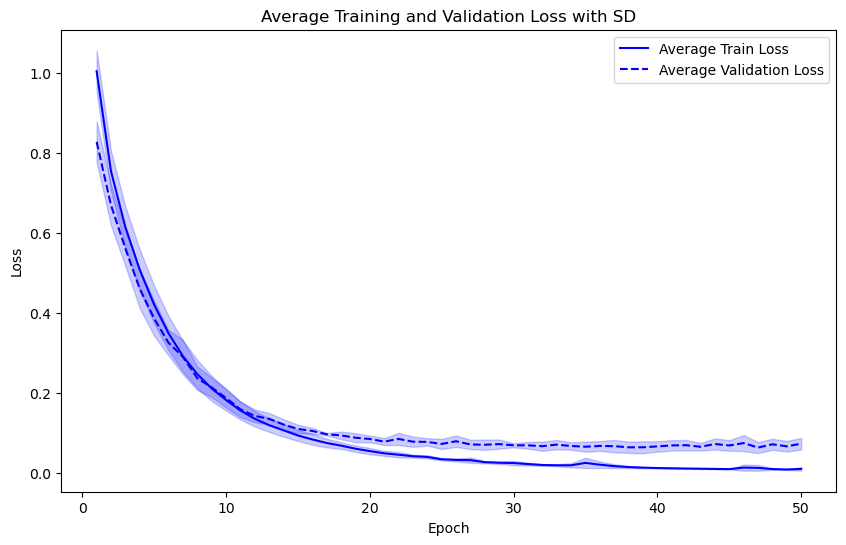

In [ ]:
#@markdown ### los curve
show_curve = True #@param{type:"boolean"}

import matplotlib.pyplot as plt
import pandas as pd
json_file_path = './content/training_history.json'
with open(json_file_path, 'w') as file:
    json.dump(fold_results, file, indent=4)

rows = []
for item in fold_results:
    for train_loss, val_loss in zip(item['train_loss'], item['val_loss']):
        rows.append({'train_loss': train_loss, 'val_loss': val_loss})

df = pd.DataFrame(rows)
csv_file_path = './content/training_history.csv'
df.to_csv(csv_file_path, index=True)

train_losses = np.array([fold['train_loss'] for fold in fold_results])
val_losses = np.array([fold['val_loss'] for fold in fold_results])

train_loss_mean = np.mean(train_losses, axis=0)
val_loss_mean = np.mean(val_losses, axis=0)
train_loss_std = np.std(train_losses, axis=0)
val_loss_std = np.std(val_losses, axis=0)

plt.figure(figsize=(10, 6))
epochs_range = np.arange(1, len(train_loss_mean) + 1)

plt.plot(epochs_range, train_loss_mean, label='Average Train Loss', color='blue')
plt.fill_between(epochs_range, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, color='blue', alpha=0.2)

plt.plot(epochs_range, val_loss_mean, label='Average Validation Loss', linestyle='--', color='blue')
plt.fill_between(epochs_range, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, color='blue', alpha=0.2)

plt.title('Average Training and Validation Loss with SD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

if show_curve:
    plt.show()

In [ ]:
#@markdown ### eval
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model = 'best_unet.pth' # @param ['final_unet.pth', 'best_unet.pth']

num_class = 4
unetmodel = UNet.load_model(model, n_channels=1, n_classes=num_class)
unetmodel = unetmodel.to(device)

import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from csbdeep.utils import normalize

doclahe = False #@param{type:"boolean"}
edgeCanny = False #@param{type:"boolean"}
lbp = False #@param{type:"boolean"}
contrast_stratergy = 'none' # @param ['linear', "cdf", "none"]
save_path = './content/output' #@param{type:"string"}
def calculate_dice_multi_class(prediction, mask, num_classes):
    dice_scores = []
    for class_index in range(1, num_classes): #ex background
        pred_bin = (prediction == class_index).astype(np.float32)
        mask_bin = (mask == class_index).astype(np.float32)

        intersection = np.sum(pred_bin * mask_bin)
        total = np.sum(pred_bin) + np.sum(mask_bin)
        if total == 0:
            dice_scores.append(1.0)
        else:
            dice_scores.append(2.0 * intersection / total)

    return np.mean(dice_scores)

def calculate_iou(prediction, mask):
    intersection = np.logical_and(prediction, mask)
    union = np.logical_or(prediction, mask)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 1
    return iou

def visualize_predictions(image_dir, mask_dir, model,show,
                          contrast = contrast_stratergy,
                          destination = save_path):
    ref_img = np.array(Image.open('./content/test/imgs/frame50_19.png').convert("L"))
    transform = transforms.Compose([
        transforms.ToTensor(),
    ]) #        transforms.Resize((256, 256)),
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    dices = 0
    ious = 0
    num = 0

    total_confusion_matrix = np.zeros((num_class, num_class))
    for filename in tqdm(os.listdir(image_dir)):
        if filename.endswith('.png'):
            num+=1
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename)

            image = Image.open(image_path).convert('L')
            mask = Image.open(mask_path).convert('L')

            image_np = np.array(image)
            if contrast == 'linear':
                image_np = ezmatch(image_np, ref_img)
            elif contrast == 'cdf':
                image_np = match_histograms(image_np, ref_img) #match_histograms

            # img_normalized = normalize(image_np, 0.0001, 99.9999, axis=(0,1))

            image_transform = transform(image_np)
            channels = [image_transform]
            channels[0] = channels[0].squeeze(0).numpy()

            if doclahe:
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                image_clahe = clahe.apply(image_np)
                channels.append(image_clahe)

            if edgeCanny:
                edges = cv2.Canny(image_np, 100, 200)
                channels.append(edges)

            if lbp:
                lbp_image = local_binary_pattern(image_np, P=8, R=1, method="uniform")
                lbp_image_normalized = cv2.normalize(lbp_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                channels.append(lbp_image_normalized)

            if len(channels) > 1:
                # print(channels[0].shape, channels[1].shape, channels[2].shape, channels[3].shape)
                image_combined = np.stack(channels, axis=-1)
            else:
                image_combined = channels[0]

            image_combined = torch.from_numpy(image_combined).float()
            if len(image_combined.size())==3:
                image_combined = image_combined.permute(2, 0, 1)
            else:
                image_combined = image_combined.unsqueeze(0)
            image_combined = image_combined.unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                prediction = model(image_combined)
                if len(prediction) > 1:
                    prediction = prediction[0]
                prediction = prediction.argmax(dim=1).squeeze(0).cpu().numpy()
                # coveg = coveg[0, 0, :, :]
                # pooleg = pooleg[0, 0, :, :]

            dice_score = calculate_dice_multi_class(prediction, np.array(mask), 5)
            iou_score = calculate_iou(prediction, np.array(mask))
            image = np.array(image)
            mask = np.array(mask)

            # mask = (255 * (mask - np.min(mask)) / np.ptp(mask)).astype(np.uint8)
            img = Image.fromarray(prediction.astype(np.uint8))
            img.save(f"{destination}/{filename}")

            # coveg = Image.fromarray(coveg.cpu().numpy().astype(np.uint8))
            # img.save(f"{destination}/coveg_{filename}")

            # pooleg = Image.fromarray(pooleg.cpu().numpy().astype(np.uint8))
            # img.save(f"{destination}/pooleg_{filename}")

            if show:
                fig, axes = plt.subplots(1, 4, figsize=(20, 5))

                axes[0].imshow(image_np, cmap='gray')
                axes[0].set_title(f'Original Image {filename}')
                axes[0].axis('off')

                axes[1].imshow(np.array(mask), cmap='CMRmap_r', vmin=0, vmax=num_class)
                axes[1].set_title('Ground Truth')
                axes[1].axis('off')

                axes[2].imshow(prediction, cmap='CMRmap_r', vmin=0, vmax=num_class)
                axes[2].set_title('Predicted Image')
                axes[2].axis('off')

                axes[3].imshow(mask, cmap='CMRmap_r', alpha=0.5, vmin=0, vmax=num_class)
                axes[3].imshow(prediction, cmap='CMRmap_r', alpha=0.5, vmin=0, vmax=num_class)
                axes[3].set_title('Overlap')
                axes[3].axis('off')

                plt.show()
            dices += dice_score
            ious += iou_score
            # print(f"Dice Score: {dice_score:.4f}, IOU Score: {iou_score:.4f}")

            prediction_flat = prediction.flatten()
            mask_flat = np.array(mask).flatten()
            cm = confusion_matrix(mask_flat, prediction_flat, labels=[0, 1, 2, 3]) #4
            total_confusion_matrix += cm
            accuracy = np.trace(cm) / np.sum(cm)

            # print('acc',accuracy, 'dic', dice_score, 'iou',iou_score)

    np.set_printoptions(suppress=True, precision=0, formatter={'float': '{:0.0f}'.format})

    # if show:
    #     plt.figure(figsize=(10, 8))
    #     sns.heatmap(total_confusion_matrix, annot=True, fmt='g', cmap='Blues')
    #     plt.xlabel('Predicted labels')
    #     plt.ylabel('True labels')
    #     plt.title('Confusion Matrix')
    #     plt.savefig('./confusion_matrix.pdf')
    #     plt.show()

    accuracy = np.trace(total_confusion_matrix) / np.sum(total_confusion_matrix)
    labels = ['Label 0', 'Label 1', 'Label 2', 'Label 3'] #, 'Label 4'
    cm_df = pd.DataFrame(total_confusion_matrix, index=[f'True {label}' for label in labels],
                     columns=[f'Pre {label}' for label in labels])
    print("Confusion Matrix:")
    print(cm_df)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Avg Dice Score: {dices/num:.4f}, Avg IOU Score: {ious/num:.4f}")


image_dir = './content/test/imgs' #@param{type:"string"}
mask_dir = './content/test/masks' #@param{type:"string"}
show_images = False #@param{type:"boolean"}

visualize_predictions(image_dir, mask_dir, unetmodel,show_images)

Output hidden; open in https://colab.research.google.com to view.

In [16]:
%%capture
#@markdown ### Out of memory Kill and reset
!pip install csbdeep
try:
    shutil.rmtree('/content/test/')
    shutil.rmtree('/content/last/')
    shutil.rmtree('/content/data/')
except:
    pass

! unzip -o -q data.zip
! unzip -o -q last.zip
! unzip -o -q test.zip
if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print("Device Index:", current_device)
    print("Device Name:", torch.cuda.get_device_name(current_device))
    print("Device Memory Allocated:", torch.cuda.memory_allocated(current_device))
    print("Device Memory Cached:", torch.cuda.memory_reserved(current_device))
    torch.cuda.empty_cache()
    print("Device Memory Cached after empty:", torch.cuda.memory_reserved(current_device))